In [69]:
import json
from pathlib import Path
import seaborn as sns; sns.set_theme()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.blocks.stats import BlockStats
from src import Block
from src import PositionalString
from tqdm import tqdm; tqdm.pandas()

In [40]:
# INPUTS
path_max_blocks_stats=Path("out/smk_max_blocks.tsv")
dir_max_blocks=Path("out/blocks/")

# load data
df = pd.read_csv(path_max_blocks_stats,sep="\t", index_col=False, header=0)#, nrows=10)


In [41]:

def path_block_from_msa(path_msa):
    name_msa = Path(path_msa).stem
    return dir_max_blocks.joinpath(f"{name_msa}.json")

def gene_or_intergenic(path_msa):
    if Path(path_msa).stem.startswith("GC"):
        return "genic"
    else:
        return "intergenic"


### Load log data from blocks

- `n_seqs`: number of sequences in the MSA
- `n_unique_seqs`: number of unique sequences in the MSA
- `n_cols`: number of columns in the MSA
- `n_max_blocks`: number of maximal blocks in that MSA
- `n_max_blocks_`: binned `n_max_blocks`
- `t`: time spent computing maximal blocks (in seconds)
- `t [min]`: same `t` in minutes
- `t_[min]`: binned `t [min]`
- `max_blocks/size_msa`: proportion [%] of maximal blocks w.r.t the size of the MSA (`n_cols x n_unique_seqs`)

In [42]:

# time in minutes
df["t [min]"] = df["t"]/60

# binned time in minutes
vec_bins=[0,1,10,15,30,45,60,120,180,300,720,1440,10_000] # bins in minutes
t_label_bins = [f"<{bin}" for bin in vec_bins[1:]]
df["t_[min]"]=pd.cut(df["t [min]"], bins=vec_bins, labels=t_label_bins)

# region
df["region"] = df["path_msa"].apply(gene_or_intergenic)    # genic or intergenic region

# max blocks binned
vec_bins=[0,3,5,10,15,50,100,150,200,300,500,1000,1500] # bins blocks
max_blocks_label_bins = [f"<{bin}" for bin in vec_bins[1:]]
df["n_max_blocks_"]=pd.cut(df["n_max_blocks"], bins=vec_bins, labels=max_blocks_label_bins)

In [43]:
# size_msa = n_rows x n_cols, n_rows: n_unique_seqs in the table
df["size_msa"] = df.apply(lambda row: row["n_unique_seqs"]*row["n_cols"], axis=1)

# proportion of maximal blocks w.r.t the size of the msa 
df["max_blocks/size_msa"] = df.apply(lambda row: round(100*row["n_max_blocks"]/row["size_msa"],2),axis=1)

In [44]:
df.head()

,timestamp,path_msa,n_seqs,n_unique_seqs,n_cols,n_max_blocks,t,t [min],t_[min],region,n_max_blocks_,size_msa,max_blocks/size_msa
0,Sat Oct 29 15:55:34 2022,/data/msas/msas/Cluster_13942.fa,19,2,38,2,0.367273,0.006121,<1,intergenic,<3,76,2.63
1,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_12332.fa,19,2,57,2,0.793138,0.013219,<1,intergenic,<3,114,1.75
2,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_11869.fa,4,2,66,4,1.171890,0.019531,<1,intergenic,<5,132,3.03
3,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_10907.fa,11,2,78,2,1.594922,0.026582,<1,intergenic,<3,156,1.28
4,Sat Oct 29 15:55:37 2022,/data/msas/msas/Cluster_10644.fa,155,3,82,5,3.114183,0.051903,<1,intergenic,<5,246,2.03


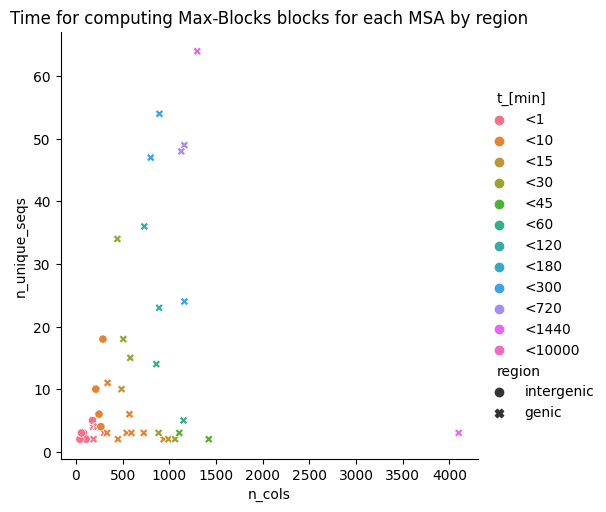

In [45]:
time_plot = sns.relplot(df,
    x="n_cols",
    y="n_unique_seqs",
    hue="t_[min]",
    style="region"
)
time_plot.set(title="Time for computing Max-Blocks blocks for each MSA by region")

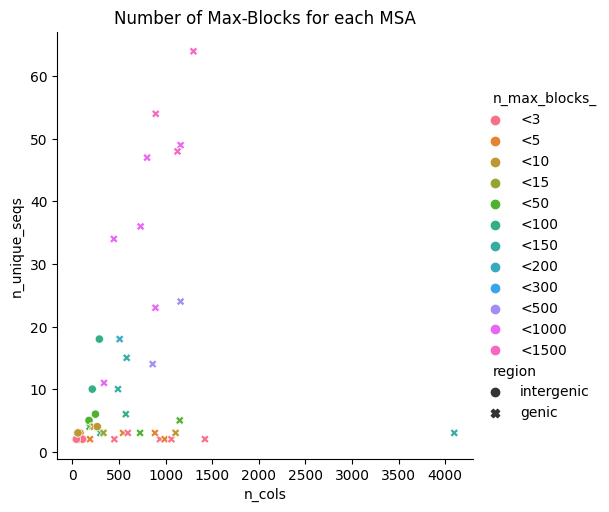

In [46]:
max_block_plot=sns.relplot(df,
    x="n_cols",
    y="n_unique_seqs",
    hue="n_max_blocks_",
    style="region"
)
max_block_plot.set(title="Number of Max-Blocks for each MSA")

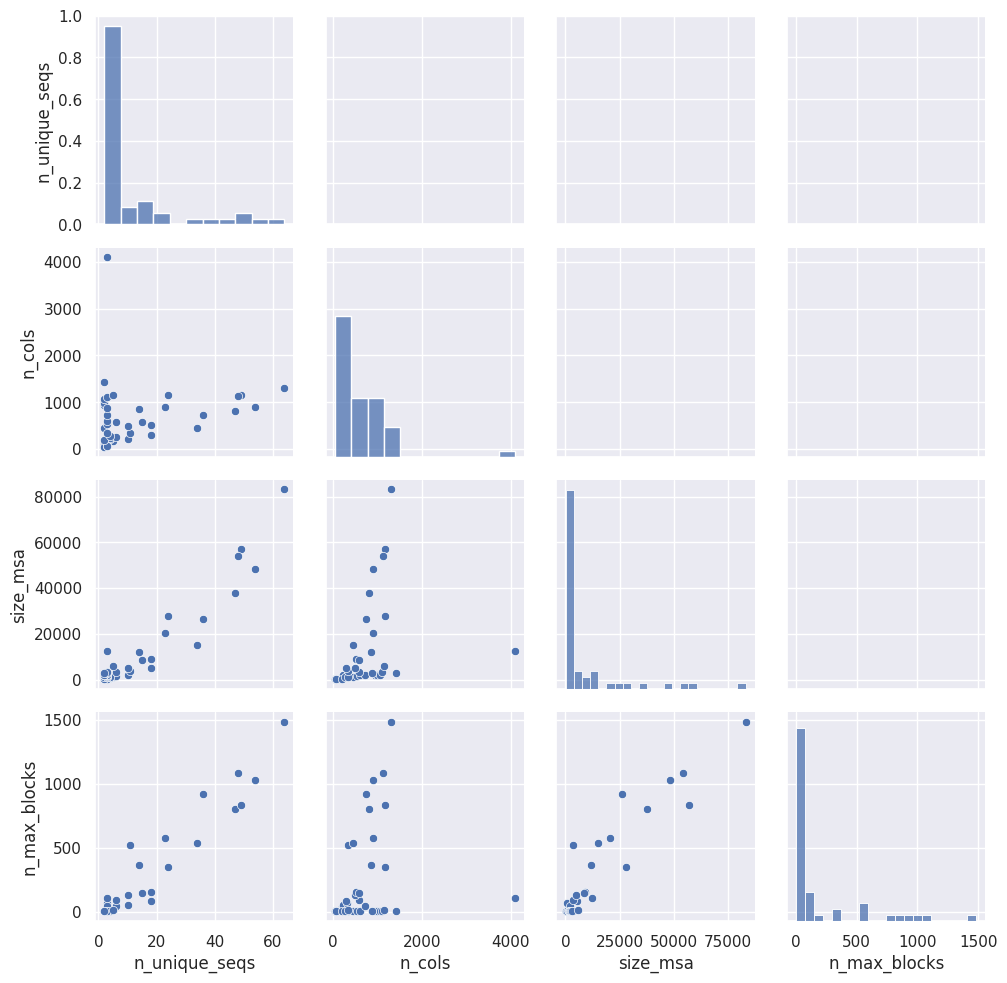

In [83]:
# g = sns.pairplot(data=df[["n_unique_seqs","n_cols","size_msa","t [min]","region"]], hue="region")
g = sns.PairGrid(data=df[["n_unique_seqs","n_cols","size_msa","n_max_blocks","region"]])#, hue="region")
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)

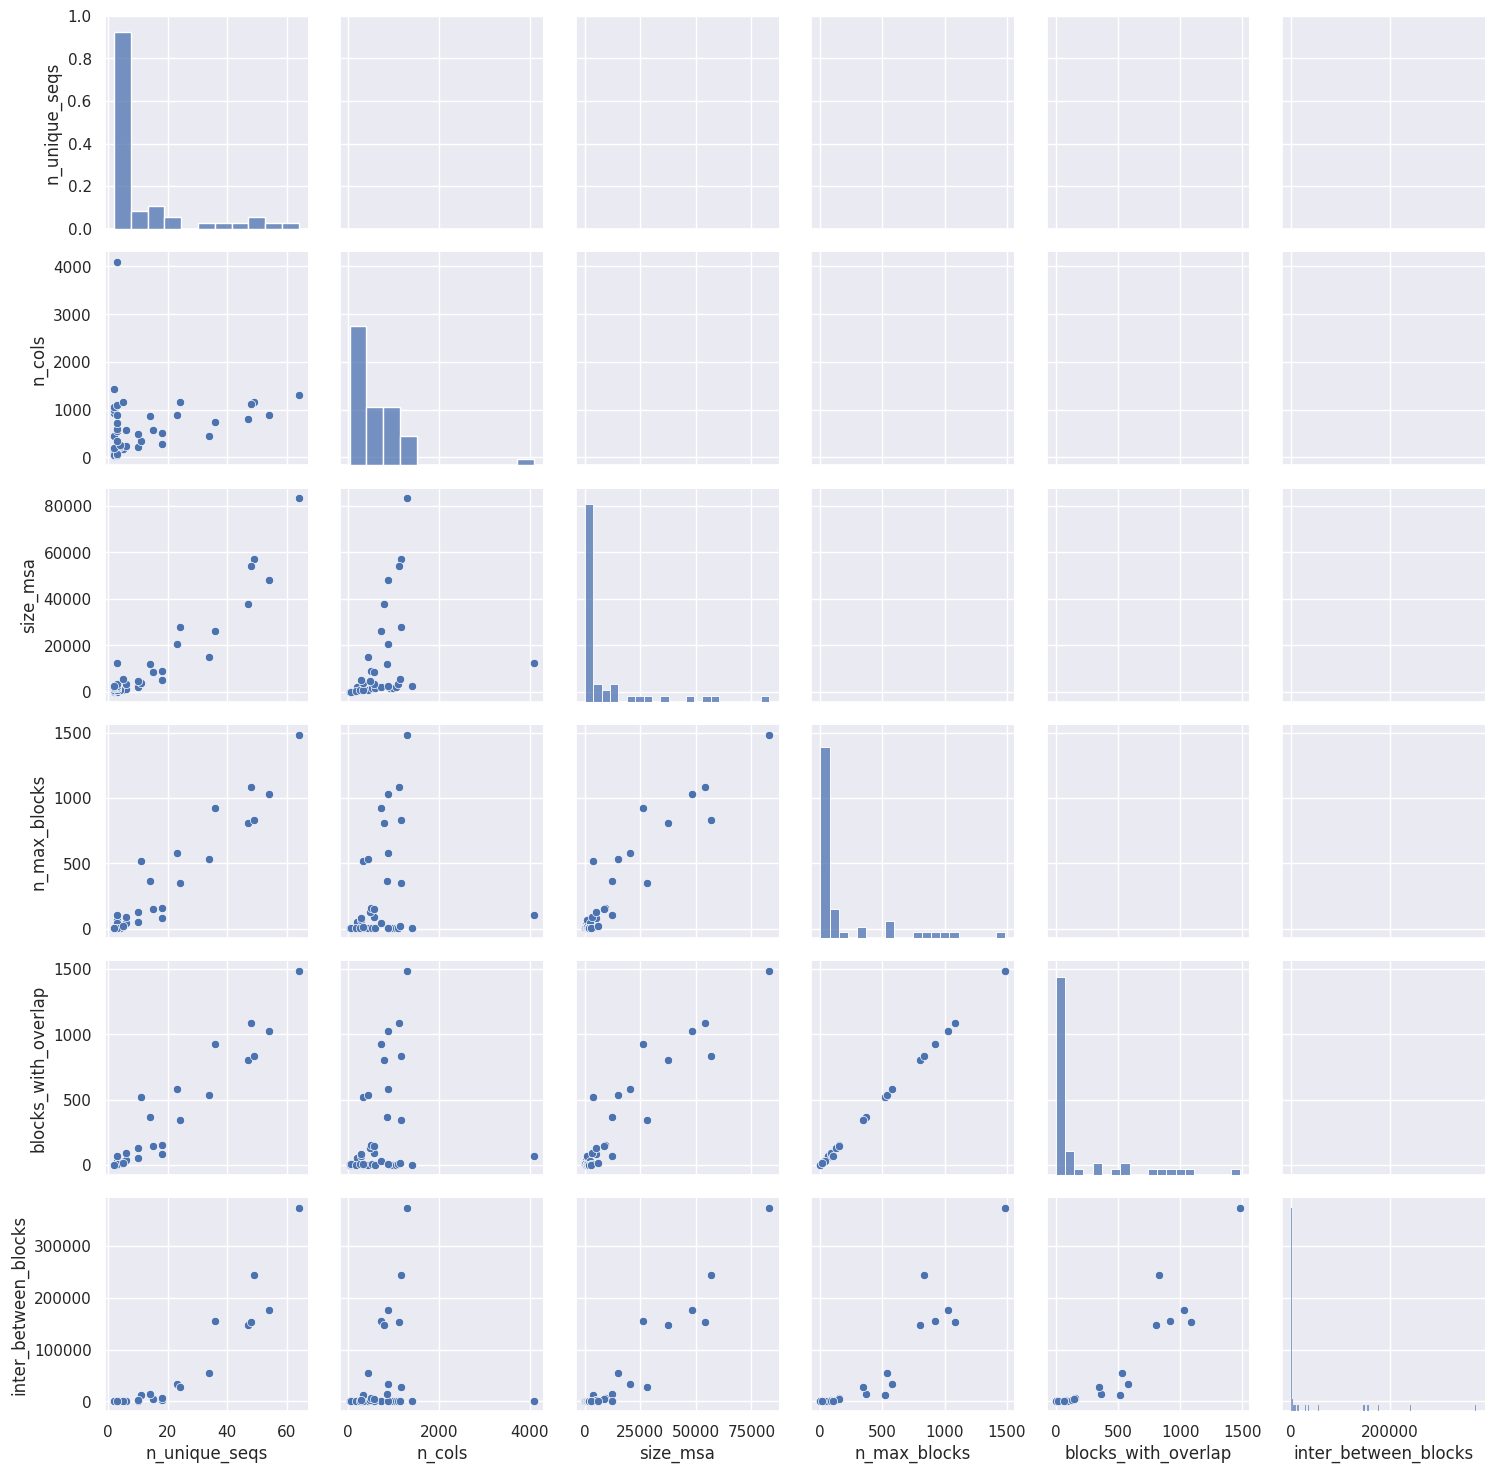

In [84]:
g = sns.PairGrid(data=df[["n_unique_seqs","n_cols","size_msa","n_max_blocks","blocks_with_overlap","inter_between_blocks","region"]])#, hue="region")
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)

# Stats for blocks
- `region`: either Genic or Intergenic
- `number_of_blocks`: number of blocks in the file, in this case is equal to `n_max_blocks`
- `blocks_with_overlap`: number of blocks that overlap at least once with another block
- `inter_between_blocks`: number of intersections between pairs of blocks

In [47]:
# statistics for each block 
block_stats=BlockStats()

df_stats=df.progress_apply(
    lambda row: block_stats(path_blocks=path_block_from_msa(row["path_msa"])),
    axis=1 ) # output is a dictionary
df = pd.concat([df, pd.DataFrame(list(df_stats))], axis=1) # add stats 

df.head()

100%|██████████| 50/50 [01:25<00:00,  1.72s/it]


,timestamp,path_msa,n_seqs,n_unique_seqs,n_cols,n_max_blocks,t,t [min],t_[min],region,n_max_blocks_,size_msa,max_blocks/size_msa,number_of_blocks,blocks_with_overlap,inter_between_blocks
0,Sat Oct 29 15:55:34 2022,/data/msas/msas/Cluster_13942.fa,19,2,38,2,0.367273,0.006121,<1,intergenic,<3,76,2.63,2,0,0
1,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_12332.fa,19,2,57,2,0.793138,0.013219,<1,intergenic,<3,114,1.75,2,0,0
2,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_11869.fa,4,2,66,4,1.171890,0.019531,<1,intergenic,<5,132,3.03,4,0,0
3,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_10907.fa,11,2,78,2,1.594922,0.026582,<1,intergenic,<3,156,1.28,2,0,0
4,Sat Oct 29 15:55:37 2022,/data/msas/msas/Cluster_10644.fa,155,3,82,5,3.114183,0.051903,<1,intergenic,<5,246,2.03,5,3,6


In [59]:
df.tail(15)

,timestamp,path_msa,n_seqs,n_unique_seqs,n_cols,n_max_blocks,t,t [min],t_[min],region,n_max_blocks_,size_msa,max_blocks/size_msa,number_of_blocks,blocks_with_overlap,inter_between_blocks
35,Sat Oct 29 16:21:57 2022,/data/msas/msas/GC00004879_5.fa,28,15,582,149,1582.971716,26.382862,<30,genic,<150,8730,1.71,149,148,4527
36,Sat Oct 29 16:22:40 2022,/data/msas/msas/GC00003247.fa,249,34,444,534,1622.277110,27.037952,<30,genic,<1000,15096,3.54,534,533,54497
37,Sat Oct 29 16:25:49 2022,/data/msas/msas/GC00005082_1.fa,7,3,1107,8,1814.918970,30.248649,<45,genic,<10,3321,0.24,8,6,14
38,Sat Oct 29 16:26:35 2022,/data/msas/msas/GC00000790_2.fa,12,2,1422,3,1861.685009,31.028083,<45,genic,<3,2844,0.11,3,0,0
39,Sat Oct 29 17:31:10 2022,/data/msas/msas/GC00000010_7.fa,13,5,1152,17,3065.197569,51.086626,<60,genic,<50,5760,0.30,17,16,122
40,Sat Oct 29 18:17:17 2022,/data/msas/msas/GC00004251_3.fa,64,36,732,923,5831.946553,97.199109,<120,genic,<1000,26352,3.50,923,922,155747
41,Sat Oct 29 18:23:08 2022,/data/msas/msas/GC00000231_12.fa,17,14,861,365,3116.324721,51.938745,<60,genic,<500,12054,3.03,365,364,13654
42,Sat Oct 29 18:31:15 2022,/data/msas/msas/GC00004517.fa,54,23,891,578,6670.227694,111.170462,<120,genic,<1000,20493,2.82,578,577,34291
43,Sat Oct 29 19:41:02 2022,/data/msas/msas/GC00000169_1.fa,302,47,801,805,10856.318501,180.938642,<300,genic,<1000,37647,2.14,805,804,147891
44,Sat Oct 29 20:34:35 2022,/data/msas/msas/GC00000764_1.fa,116,24,1161,346,14070.189344,234.503156,<300,genic,<500,27864,1.24,346,345,27679


### mean and max of some features by genic/intergenic region


In [48]:
features0=["n_unique_seqs","n_cols"]
features1=["n_max_blocks","t [min]"]
features2=["blocks_with_overlap", "inter_between_blocks"]
features3=["size_msa","max_blocks/size_msa"]

In [49]:
df.groupby("region")[features0].describe()

n_unique_seqs                                                    \
                   count       mean        std  min  25%  50%    75%   max   
region                                                                       
genic               36.0  14.333333  17.965045  2.0  3.0  4.0  19.25  64.0   
intergenic          14.0   4.571429   4.467219  2.0  2.0  3.0   4.75  18.0   

           n_cols                                                         \
            count        mean         std    min     25%    50%      75%   
region                                                                     
genic        36.0  777.083333  675.429953  177.0  337.50  660.0  1008.00   
intergenic   14.0  127.285714   91.302901   38.0   57.75   80.0   204.25   

                    
               max  
region              
genic       4098.0  
intergenic   289.0

In [50]:
df.groupby("region")[features1].describe()

n_max_blocks                                                  \
                  count        mean         std  min   25%   50%    75%   
region                                                                    
genic              36.0  260.666667  393.483708  2.0  4.75  35.5  404.0   
intergenic         14.0   17.357143   25.037225  2.0  2.25   5.5   18.5   

                   t [min]                                              \
               max   count        mean         std       min       25%   
region                                                                   
genic       1484.0    36.0  105.038068  212.480913  0.185219  1.600133   
intergenic    84.0    14.0    0.656113    1.354664  0.006121  0.018736   

                                              
                  50%        75%         max  
region                                        
genic       14.346342  63.253836  845.469212  
intergenic   0.038589   0.891968    5.061746

In [51]:
df.groupby("region")[features2].describe()

blocks_with_overlap                                          \
                         count        mean         std  min  25%   50%   
region                                                                   
genic                     36.0  257.555556  394.582633  0.0  2.5  28.0   
intergenic                14.0   15.428571   25.578580  0.0  0.0   3.5   

                           inter_between_blocks                              \
               75%     max                count          mean           std   
region                                                                        
genic       402.75  1483.0                 36.0  39158.333333  84538.832639   
intergenic   17.50    83.0                 14.0    368.642857    869.005940   

                                                  
            min   25%    50%       75%       max  
region                                            
genic       0.0  4.75  111.0  17160.25  374420.0  
intergenic  0.0  0.00    7.5    148.75    3067.0

In [52]:
df.groupby("region")[features3].describe()

size_msa                                                     \
              count          mean           std    min     25%     50%   
region                                                                   
genic          36.0  12729.250000  19789.686864  372.0  996.75  3082.5   
intergenic     14.0    867.428571   1398.575853   76.0  138.00   200.0   

                             max_blocks/size_msa                            \
                75%      max               count      mean       std   min   
region                                                                       
genic       12994.5  83136.0                36.0  1.945833  2.540672  0.09   
intergenic   1023.5   5202.0                14.0  2.344286  1.042598  0.75   

                                       
              25%   50%    75%    max  
region                                 
genic       0.300  1.52  2.260  13.97  
intergenic  1.645  2.40  2.735   4.94

___
## Draft [do not consider]

In [53]:
from src.blocks.block_decomposition import block_decomposition
from src.blocks.block import Block

In [54]:
b1 = Block([1,2,3],1,5,"ACGTT")
b2 = Block([2,3],1,3,"ACG")
block_decomposition(b1,b2)

Condicion1


[Block(K=[2, 3], i=1, j=3, label='ACG'),
 Block(K=[1, 2, 3], i=4, j=5, label='TT')]

In [55]:
b1 = Block([2,3],1,5,"ACGTT")
b2 = Block([1,2,3],2,4,"CGT")

block_decomposition(b1,b2)

Condicion2


[Block(K=[2, 3], i=1, j=1, label='A'),
 Block(K=[1, 2, 3], i=2, j=4, label='CGT'),
 Block(K=[2, 3], i=5, j=5, label='T')]

In [56]:
b1 = Block([1,2],1,5,"ACGTT")
b2 = Block([1,2,3],4,5,"TT")
block_decomposition(b1,b2)

Condicion3


[Block(K=[1, 2], i=1, j=3, label='ACG'),
 Block(K=[1, 2, 3], i=4, j=5, label='TT')]

In [57]:
b1 = Block([1,2],1,4,"ACGT")
b2 = Block([2,3],3,5,"GTT")
block_decomposition(b1,b2)

Condicion4


[Block(K=[1, 2], i=1, j=2, label='AC'),
 Block(K=[2, 3], i=3, j=5, label='GTT'),
 Block(K=[1, 2], i=1, j=4, label='ACGT'),
 Block(K=[2, 3], i=5, j=5, label='T')]